In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

## Load and Transform Input Data

In [3]:
# asset price data
df_price = pd.read_excel('AssetData.xlsx', sheet_name='Sheet1')

In [4]:
df_price.head()

,Dates,Asset1,Asset2,Asset3,Asset4,Asset5,Asset6,Asset7
0,2018-11-07,5457.25,5593.924,456.281,173.6944,1226.11,289.1945,2147.45
1,2018-11-06,5457.25,5593.924,456.281,173.5643,1227.19,289.1945,2147.45
2,2018-11-05,5422.88,5578.525,456.298,174.6514,1231.49,289.1822,2148.31
3,2018-11-02,5392.53,5600.191,458.281,173.9684,1232.89,288.4757,2145.95
4,2018-11-01,5426.33,5567.267,446.660,173.3351,1233.43,289.3517,2154.29


In [5]:
df_price.tail()

,Dates,Asset1,Asset2,Asset3,Asset4,Asset5,Asset6,Asset7
3148,2006-10-13,2095.97,4161.805,278.122,306.581,590.4,187.4862,1435.27
3149,2006-10-12,2091.68,4156.308,273.561,302.524,579.3,187.7168,1436.96
3150,2006-10-11,2071.90,4139.568,271.947,301.696,573.0,187.6959,1436.25
3151,2006-10-10,2077.01,4137.883,272.080,300.518,573.0,188.3498,1438.84
3152,2006-10-09,2072.71,4132.929,270.747,303.717,577.1,188.9718,1441.94


The provided asset price file contains daily asset price data of 7 unnamed assets, starting from 10/09/2006 through 11/07/2018.

In [6]:
df_price.dtypes

Dates     datetime64[ns]
Asset1           float64
Asset2           float64
Asset3           float64
Asset4           float64
Asset5           float64
Asset6           float64
Asset7           float64
dtype: object

Data types are already the expected data types. No conversion needed.

In [7]:
# convert to time series
df_price = df_price.rename(columns={"Dates" : "Date"}).set_index("Date").fillna(method="ffill")

Note the original price data are sorted in descending order. Let's rearrange it so that the prices are sorted in ascending order by date.

In [8]:
df_price = df_price.sort_index()

Next, we load and transform the risk free rates.

In [9]:
# use 3-month treasury bill yield as the proxy of risk free rate
# source: https://fred.stlouisfed.org/series/DGS3MO
df_rf = pd.read_csv('DGS3MO.csv')

In [10]:
df_rf.dtypes

DATE      object
DGS3MO    object
dtype: object

In [11]:
# convert date strings to python date
df_rf['DATE'] = pd.to_datetime(df_rf['DATE'])

# convert rates from string format to numeric, also scale it from percentage to decimal
df_rf['DGS3MO'] = pd.to_numeric(df_rf['DGS3MO'], errors='coerce') / 100

# convert the data frame to a pandas time series, and fill NaN's with the last observation
df_rf = df_rf.rename(columns={"DGS3MO" : "Rf", "DATE" : "Date"}).set_index('Date').fillna(method="ffill")

In [12]:
df_rf.head()

,Rf
Date,
2006-10-02,0.0488
2006-10-03,0.0490
2006-10-04,0.0493
2006-10-05,0.0494
2006-10-06,0.0495


In [13]:
df_rf.tail()

,Rf
Date,
2018-11-05,0.0236
2018-11-06,0.0235
2018-11-07,0.0237
2018-11-08,0.0235
2018-11-09,0.0236


## Data Analysis

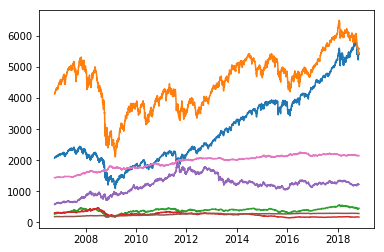

In [14]:
plt.plot(df_price.index, df_price)
plt.show()

Calculate returns

In [15]:
# calculate daily asset returns
df_dret = df_price.pct_change()

In [16]:
# TODO drop partial months at the head and tail of the dataset

In [17]:
# monthly returns
df_mret = df_dret.groupby([df_dret.index.year, df_dret.index.month]).apply(lambda x: (x + 1).prod() - 1)

In [18]:
df_mret.head()

Asset1    Asset2    Asset3    Asset4    Asset5    Asset6  \
Date Date                                                               
2006 10    0.020717  0.031099  0.041334  0.027512  0.051118  0.004911   
     11    0.019020  0.029884  0.074321  0.054689  0.068249  0.012365   
     12    0.014027  0.031392  0.045029 -0.045929 -0.017438 -0.023325   
2007 1     0.015123  0.006767 -0.010558  0.002105  0.025915  0.001308   
     2    -0.019561  0.008069 -0.005936  0.033675  0.024724  0.021345   

             Asset7  
Date Date            
2006 10    0.007740  
     11    0.010447  
     12   -0.008221  
2007 1    -0.001593  
     2     0.016583

In [19]:
df_mret.tail()

Asset1    Asset2    Asset3    Asset4    Asset5    Asset6  \
Date Date                                                               
2018 7     0.037215  0.024615  0.021968 -0.021343 -0.022713 -0.004811   
     8     0.032584 -0.019313 -0.027040 -0.017705 -0.018789  0.007203   
     9     0.005692  0.008679 -0.005306  0.019176 -0.008550 -0.010531   
     10   -0.068350 -0.079592 -0.087084 -0.021588  0.020052 -0.014333   
     11    0.016344  0.011039  0.038184  0.006887  0.009343 -0.001940   

             Asset7  
Date Date            
2018 7    -0.004184  
     8     0.007650  
     9    -0.009337  
     10   -0.004777  
     11   -0.002063

Calculate pairwise correlations of all assets.

In [20]:
correlations = df_mret.corr()

In [21]:
correlations

,Asset1,Asset2,Asset3,Asset4,Asset5,Asset6,Asset7
Asset1,1.000000,0.885000,0.777448,0.490516,0.039186,0.166864,-0.300731
Asset2,0.885000,1.000000,0.879513,0.579386,0.137040,0.253404,-0.240814
Asset3,0.777448,0.879513,1.000000,0.643828,0.285577,0.343636,-0.191987
Asset4,0.490516,0.579386,0.643828,1.000000,0.484597,0.348102,-0.159402
Asset5,0.039186,0.137040,0.285577,0.484597,1.000000,0.517791,0.351385
Asset6,0.166864,0.253404,0.343636,0.348102,0.517791,1.000000,0.585950
Asset7,-0.300731,-0.240814,-0.191987,-0.159402,0.351385,0.585950,1.000000


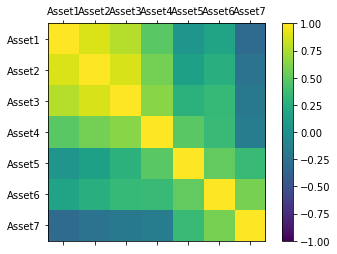

In [22]:
# plot correlation matrix
names = df_mret.columns
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(correlations, vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,7,1)
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels(names)
ax.set_yticklabels(names)
plt.show()

Scatterplots

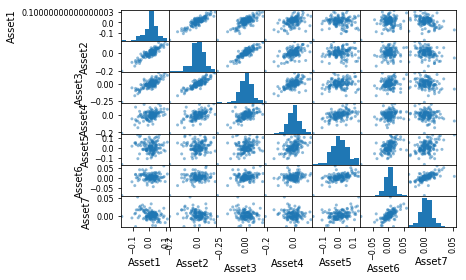

In [23]:
from pandas.plotting import scatter_matrix
scatter_matrix(df_mret)
plt.show()

In [24]:
# return statistics
df_mret.describe()

,Asset1,Asset2,Asset3,Asset4,Asset5,Asset6,Asset7
count,146.000000,146.000000,146.000000,146.000000,146.000000,146.000000,146.000000
mean,0.007516,0.003357,0.005642,-0.002644,0.006511,0.003061,0.002799
std,0.041322,0.050165,0.063609,0.047990,0.051876,0.016891,0.011645
min,-0.167951,-0.201783,-0.273677,-0.212832,-0.168896,-0.086914,-0.029161
25%,-0.013965,-0.019609,-0.026356,-0.027678,-0.024180,-0.005018,-0.003615
50%,0.013265,0.008267,0.003522,0.001324,0.004466,0.003365,0.001203
75%,0.032278,0.031824,0.040992,0.025504,0.040433,0.011003,0.008910
max,0.109292,0.128041,0.170869,0.130045,0.130137,0.058448,0.053071


## Portfolio Optimization

Assumptions

* Historical returns are used as the proxy for expected returns of assets
* Historical covariances are used as the proxy for expected covariances between assets

In [28]:
R_exp = df_mret.mean() * 12

In [99]:
R_exp.round(3) * 100

Asset1    9.0
Asset2    4.0
Asset3    6.8
Asset4   -3.2
Asset5    7.8
Asset6    3.7
Asset7    3.4
dtype: float64

In [101]:
CovMat_exp = np.cov(df_mret, rowvar=False)

In [105]:
df_mret.corr()

,Asset1,Asset2,Asset3,Asset4,Asset5,Asset6,Asset7
Asset1,1.000000,0.885000,0.777448,0.490516,0.039186,0.166864,-0.300731
Asset2,0.885000,1.000000,0.879513,0.579386,0.137040,0.253404,-0.240814
Asset3,0.777448,0.879513,1.000000,0.643828,0.285577,0.343636,-0.191987
Asset4,0.490516,0.579386,0.643828,1.000000,0.484597,0.348102,-0.159402
Asset5,0.039186,0.137040,0.285577,0.484597,1.000000,0.517791,0.351385
Asset6,0.166864,0.253404,0.343636,0.348102,0.517791,1.000000,0.585950
Asset7,-0.300731,-0.240814,-0.191987,-0.159402,0.351385,0.585950,1.000000


In [34]:
def port_return(w, R):
    return np.sum(w * R)

In [38]:
n_assets = df_mret.columns.size

In [40]:
w = np.array([1./n_assets] * n_assets)

In [41]:
port_return(w, R_exp)

0.04498528960471392

In [72]:
def port_vol(w, Cov):
    return np.sqrt(np.dot(w.T, np.dot(Cov, w)))

In [71]:
port_vol(w, CovMat_exp)

0.02975852475059659

In [74]:
def min_fun(w, R, Cov):
    return -1 * port_return(w, R) / port_vol(w, Cov)

In [88]:
from scipy.optimize import minimize

def port_optimize(R, Cov, min_wt = 0.05, max_wt = 0.2, req_ret = 0.05):
    """Maximize the sharpe ratio to find the optimal weights"""
    n_assets = R.size
    
    cons = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1}, 
            {'type': 'ineq', 'fun': lambda x: port_return(x, R) - req_ret})
    
    bnds = tuple((min_wt, max_wt) for x in range(n_assets))
    
    opt = minimize(min_fun,
                   x0=np.array([1./n_assets] * n_assets),
                   args=(R, Cov),
                   method='SLSQP',
                   bounds=bnds,
                   constraints=cons)

    opt_weights = opt['x']

    return  opt_weights

In [92]:
opt_weight = port_optimize(R_exp, CovMat_exp, min_wt = 0.05, max_wt=1.)
print(np.round(opt_weight, decimals=2))
np.sum(opt_weight)

[0.25 0.05 0.05 0.05 0.08 0.05 0.47]


1.0000000000170672

In [93]:
port_return(opt_weight, R_exp)

0.05000001887185236

In [94]:
port_vol(opt_weight, CovMat_exp)

0.018119032071459592